In [91]:
import pandas as pd
import numpy as np
from scipy import stats

from keras.layers import Dense, Flatten, Dropout, Conv1D, MaxPooling1D, LSTM
from keras.models import Sequential
from keras.utils import to_categorical, plot_model
from keras.preprocessing import timeseries_dataset_from_array

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix as pcm

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

### Utils

In [9]:
# Функции для разделения временного ряда на окна размера 128

def windows(data, size):
    start = 0
    while start < data.count():
        yield int(start), int(start + size)
        start += (size / 2)
        
def segment_signal(data, window_size=128):
    segments = np.empty((0, window_size, 9))
    labels = np.empty((0))
    sensors = {}
    for (start, end) in windows(data['timestamp'], window_size):
        for column in data.columns[:-2]:
            sensors[column] = data[column][start:end]
        if(len(data['timestamp'][start:end]) == window_size):
            segments = np.vstack([segments,np.dstack([
                sensors['accX'], sensors['accY'], sensors['accZ'], 
                sensors['gyrX'], sensors['gyrY'], sensors['gyrZ'],
                sensors['magX'], sensors['magY'], sensors['magZ']
            ])])
            labels = np.append(labels, stats.mode(data['activityMode'][start:end])[0][0])
    return segments, labels

In [66]:
def plot_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    ax[0].plot(history.epoch, history.history['accuracy'], label='accuracy')
    ax[0].plot(history.epoch, history.history['val_accuracy'], label='val accuracy')
    ax[1].plot(history.epoch, history.history['loss'], label='loss')
    ax[1].plot(history.epoch, history.history['val_loss'], label='val loss')
    ax[0].set_xlabel('epochs')
    ax[1].set_xlabel('epochs')
    ax[0].legend()
    ax[1].legend()
    plt.show()

In [69]:
def plot_confusion_matrix(model, test_x, test_y):
    pred = model.predict(test_x)
    pred = np.argmax(pred, axis = 1) 
    y_true = np.argmax(test_y, axis = 1)

    cm = confusion_matrix(y_true, pred)
    fig, ax = pcm(conf_mat=cm, 
                  figsize=(10, 5), 
                  show_absolute=True,
                  show_normed=True,
                  colorbar=True)
    plt.show()

### Load dataset

In [5]:
df = pd.read_csv('data/sensors/final_sens.csv')

In [6]:
df.head()

,accX,accY,accZ,gyrX,gyrY,gyrZ,magX,magY,magZ,activityMode,timestamp
0,0.271171,0.494363,0.481294,0.464341,0.706660,0.434324,0.830153,0.173021,0.692042,2,1900-01-01 00:00:00.011858
1,0.273197,0.493490,0.483091,0.463672,0.709244,0.437396,0.830153,0.173021,0.692042,2,1900-01-01 00:00:00.056658
2,0.273197,0.493490,0.483091,0.463672,0.709244,0.437396,0.830153,0.173021,0.692042,2,1900-01-01 00:00:00.057395
3,0.273197,0.493490,0.483091,0.463672,0.709244,0.437396,0.830153,0.173021,0.692042,2,1900-01-01 00:00:00.058396
4,0.273197,0.493490,0.483091,0.463672,0.709244,0.437396,0.830153,0.173021,0.692042,2,1900-01-01 00:00:00.059396


In [7]:
df['activityMode'].value_counts()

1    340637
0    287330
2    278939
Name: activityMode, dtype: int64

### Split the dataset into intervals of 128 timestamps

In [10]:
segments, labels = segment_signal(df)
labels = np.asarray(pd.get_dummies(labels), dtype = np.int8)

In [53]:
print(segments.shape)
print(labels.shape)

(14169, 128, 9)
(14169, 3)


In [20]:
train_x, test_x, train_y, test_y = train_test_split(segments, labels, test_size=0.20)

### Save a split dataset 

In [61]:
def save_split_data(data, folder, prefix, postfix):
    for i, column in enumerate(df.columns[:-2]):
        with open('data/sensors/' 
            + folder + '/'
            + prefix + '/' 
            + prefix + '_sensors_split_' 
            + column + '_' 
            + postfix +'.npy', 'wb') as f:
            # If 3d or 2d array
            if len(data.shape) == 3:
                np.save(f, data[:, :, i])
            else:
                np.save(f, data)

In [63]:
save_split_data(train_x, 'original', 'train', 'segments')
save_split_data(test_x, 'original', 'test', 'segments')
save_split_data(train_y, 'original', 'train', 'labels')
save_split_data(test_y, 'original', 'test', 'labels')

### Load train and test data

In [64]:
n_timestamps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]

### Ver. 1. Original data (CNN)

In [71]:
model = Sequential()
model.add(Conv1D(128, 3, activation='relu', input_shape=(n_timestamps, n_features)))
model.add(Conv1D(128, 3, activation='relu'))
model.add(Conv1D(128, 3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))

In [76]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy', 'AUC', 'Precision', 'Recall'])

In [77]:
history = model.fit(train_x, train_y, epochs=80, batch_size=10, validation_split=0.1)

acy: 0.9441 - auc: 0.9910 - precision: 0.9490 - recall: 0.9405 - val_loss: 0.0927 - val_accuracy: 0.9780 - val_auc: 0.9961 - val_precision: 0.9805 - val_recall: 0.9735
Epoch 5/80
1021/1021 [==============================] - 45s 44ms/step - loss: 0.1282 - accuracy: 0.9627 - auc: 0.9941 - precision: 0.9638 - recall: 0.9606 - val_loss: 0.1007 - val_accuracy: 0.9683 - val_auc: 0.9956 - val_precision: 0.9699 - val_recall: 0.9647
Epoch 6/80
1021/1021 [==============================] - 45s 44ms/step - loss: 0.1381 - accuracy: 0.9543 - auc: 0.9937 - precision: 0.9569 - recall: 0.9520 - val_loss: 0.1885 - val_accuracy: 0.9568 - val_auc: 0.9909 - val_precision: 0.9615 - val_recall: 0.9250
Epoch 7/80
1021/1021 [==============================] - 44s 43ms/step - loss: 0.1102 - accuracy: 0.9685 - auc: 0.9951 - precision: 0.9709 - recall: 0.9666 - val_loss: 0.1426 - val_accuracy: 0.9683 - val_auc: 0.9941 - val_precision: 0.9708 - val_recall: 0.9683
Epoch 8/80
1021/1021 [==============================

In [82]:
metrics = model.evaluate(test_x, test_y)

89/89 [==============================] - 3s 32ms/step - loss: 0.0963 - accuracy: 0.9732 - auc: 0.9969 - precision: 0.9735 - recall: 0.9728


In [110]:
print(f'loss = {metrics[0]}')
print(f'accuracy = {metrics[1]}')
print(f'auc = {metrics[2]}')
print(f'precision = {metrics[3]}')
print(f'recall = {metrics[4]}')

loss = 0.09634936600923538
accuracy = 0.9731827974319458
auc = 0.9968516230583191
precision = 0.9735169410705566
recall = 0.9728299379348755


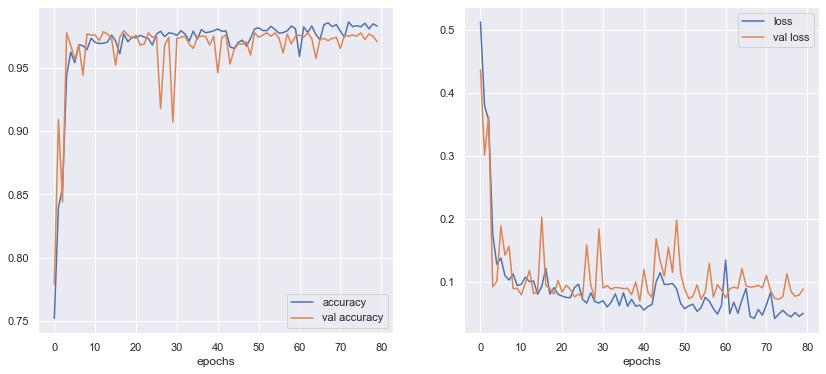

In [79]:
plot_history(history)

In [80]:
model.save('models/cnn-v2.0.h5')

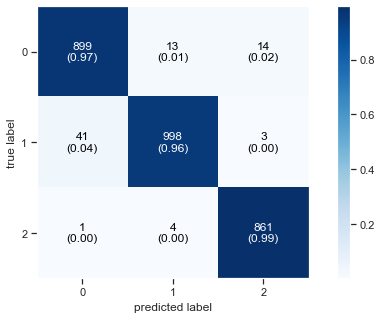

In [81]:
plot_confusion_matrix(model, test_x, test_y)